In [1]:
import math
from copy import deepcopy
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer

In [2]:
data = pd.read_csv('data/winemag-data-130k-v2.csv', sep=",", index_col=0)
data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
data.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

In [4]:
data.shape

(129971, 13)

## Project goal

The goal of this project is to predict the quality of wine based on several factors, such as place of winemaking (country, province, region, designation), winery, variety, price.

## Data cleaning

In [5]:
new_data = data.drop(columns=["taster_name", "taster_twitter_handle", "title", "description"])
new_data.sample(5)

,country,designation,points,price,province,region_1,region_2,variety,winery
119489,US,NaN,86,11.0,Virginia,Virginia,NaN,Chambourcin,Molliver Vineyards
33280,Italy,Lenzi Riserva,87,37.0,Tuscany,Chianti Classico,NaN,Sangiovese,Fattoria di Petroio
38808,Italy,Brut,88,30.0,Lombardy,Franciacorta,NaN,Sparkling Blend,Ronco Calino
32287,US,Lafond Vineyard,93,40.0,California,Sta. Rita Hills,Central Coast,Chardonnay,Lafond
43438,US,Jack London Vineyard,87,25.0,California,Sonoma Mountain,Sonoma,Merlot,Kenwood


In [6]:
new_data.to_csv("data/wine_cleaned.csv", index=False)

## Dealing with missing values

In [7]:
new_data["country"].dtype == 'O'

True

In [27]:
def check_for_missings(data):
    columns_with_missings = []
    for col in data.columns:
        if pd.isnull(data[col].unique()).any():
            print(f"Column '{col}' has {data[pd.isnull(data[col])].shape[0]} missing values")
            columns_with_missings.append(col)
    return columns_with_missings

In [28]:
mv_replaced_data = deepcopy(new_data)
columns_with_missings = check_for_missings(mv_replaced_data)

Column 'country' has 63 missing values
Column 'designation' has 37465 missing values
Column 'price' has 8996 missing values
Column 'province' has 63 missing values
Column 'region_1' has 21247 missing values
Column 'region_2' has 79460 missing values
Column 'variety' has 1 missing values


### Apply global most common substitution

In [33]:
for col in filter(lambda c: mv_replaced_data[c].dtype == "O", columns_with_missings):
    most_popular = mv_replaced_data[col].mode()
    mv_replaced_data.loc[pd.isnull(mv_replaced_data[col]), col] = most_popular[0]
end = time()

In [30]:
new_columns_with_missings = check_for_missings(mv_replaced_data)

Column 'price' has 8996 missing values


In [31]:
mean = mv_replaced_data.price.mean()
mv_replaced_data.loc[pd.isnull(mv_replaced_data["price"]), "price"] = np.round(mean, 4)

In [32]:
check_for_missings(mv_replaced_data)

[]

### Test performance

#### Prepare data

Split data into X and y.

In [22]:
data_for_model = deepcopy(mv_replaced_data)
y = data_for_model.points
X = data_for_model.drop(columns=["points"])
X.sample(5)

,country,designation,price,province,region_1,region_2,variety,winery
34374,US,Acquisition,49.0,Washington,Red Mountain,Columbia Valley,Cabernet Sauvignon,Market Vineyards
88905,France,Reserve,10.0,Languedoc-Roussillon,Vin de Pays d'Oc,Central Coast,Chardonnay,The Frenchhouse
23494,Australia,Bremerview,20.0,South Australia,Langhorne Creek,Central Coast,Shiraz,Bleasdale
17755,Australia,The Dry Dam,17.0,South Australia,McLaren Vale-Adelaide Hills,Central Coast,Riesling,D'Arenberg
71062,US,Reserve,25.0,California,Mendocino County,Central Coast,Petite Sirah,Artezin


Transform string values in X into numerical ones. Note that we can not use function pandas.get_dummies(), as columns have many different values, which results into too much columns to fit into memory. So we have to maually assign to every unique value in column a number.
Note also that almost every column has to be transformed except for 'price'

In [23]:
for col in ["country", "province", "region_1", "region_2", "variety", "winery"]:
    unique = X[col].unique()
    mapping = dict(map(lambda x: [x[1], x[0]], enumerate(unique)))
    new_col = X[col].replace(mapping)
    X[col] = new_col

In [ ]:
col = "designation"
unique = X[col].unique()
mapping = dict(map(lambda x: [x[1], x[0]], enumerate(unique)))
new_col = X[col].replace(mapping)
X[col] = new_col

Split X and y into train and test parts with 4:1 correspondence

In [207]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train linear regression and test its performance

In [208]:
lr = LinearRegression()
lr.fit(x_train, y_train)
print("Train accuracy:", lr.score(x_train, y_train))
print("Test accuracy:",  lr.score(x_test, y_test))

Train accuracy: 0.18018379153289743
Test accuracy: 0.17184699220932476


### Apply KNN approach

In [ ]:
knn_replaced_data = new_data.copy(deep=True)


Investigate amount of missing values in each column

In [ ]:
for col in knn_replaced_data.columns:
    print(f"Missings in '{col}' column: {knn_replaced_data[pd.isnull(knn_replaced_data[col])].shape[0]}")

### Impute column 'country'

Impute other columns using global most common substitution

In [ ]:
categ_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
num_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [ ]:
dataset = knn_replaced_data.copy(deep=True)
dataset[["designation", "province", "region_1", "region_2", "variety"]] = \
    categ_imputer.fit_transform(dataset[["designation", "province", "region_1", "region_2",
                                         "variety"]])
dataset[["price"]] = num_imputer.fit_transform(dataset[["price"]])

Get dummies

In [ ]:
for col in ["province", "region_1", "region_2", "variety", "winery"]:
    unique = dataset[col].unique()
    mapping = dict(map(lambda x: [x[1], x[0]], enumerate(unique)))
    new_col = dataset[col].replace(mapping)
    dataset[col] = new_col

In [ ]:
col = "designation"
unique = dataset[col].unique()
mapping = dict(map(lambda x: [x[1], x[0]], enumerate(unique)))
new_col = dataset[col].replace(mapping)
dataset[col] = new_col

Get rows for train and predict

In [ ]:
target = "country"
# for train
train = dataset[np.bitwise_not(pd.isnull(dataset.country))]
x_train = train.loc[:, train.columns != target]
y_train = train.loc[:, train.columns == target]

# for predict
predict = dataset[pd.isnull(dataset.country)]
x_predict = predict.loc[:, predict.columns != target]

Train KNN

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=30, leaf_size=100, n_jobs=-1)
knn_classifier.fit(x_train, y_train)

Make prediction

In [ ]:
y_predict = knn_classifier.predict(x_predict)
dataset.country[pd.isnull(dataset.country)] = y_predict

In [ ]:
knn_replaced_data.country = dataset.country

In [ ]:
knn_replaced_data.head(5)

### Impute 'designation'

In [ ]:
dataset = knn_replaced_data.copy(deep=True)
dataset[["province", "region_1", "region_2", "variety"]] = \
    categ_imputer.fit_transform(dataset[["province", "region_1", "region_2", "variety",]])
dataset[["price"]] = num_imputer.fit_transform(dataset[["price"]])

In [ ]:
for col in ["country", "province", "region_1", "region_2", "variety", "winery"]:
    unique = dataset[col].unique()
    mapping = dict(map(lambda x: [x[1], x[0]], enumerate(unique)))
    new_col = dataset[col].replace(mapping)
    dataset[col] = new_col

In [ ]:
target = "designation"
# for train
train = dataset[np.bitwise_not(pd.isnull(dataset[target]))]
x_train = train.loc[:, train.columns != target]
y_train = train.loc[:, train.columns == target]

# for predict
predict = dataset[pd.isnull(dataset[target])]
x_predict = predict.loc[:, predict.columns != target]

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=30, leaf_size=100, n_jobs=-1)
knn_classifier.fit(x_train, y_train)

In [ ]:
y_predict = knn_classifier.predict(x_predict)
dataset.designation[pd.isnull(dataset.designation)] = y_predict

In [ ]:
knn_replaced_data.designation = dataset.designation

In [ ]:
knn_replaced_data.head()

### Impute 'province'

In [ ]:
dataset = knn_replaced_data.copy(deep=True)
dataset[["region_1", "region_2", "variety"]] = \
    categ_imputer.fit_transform(dataset[["region_1", "region_2", "variety",]])
dataset[["price"]] = num_imputer.fit_transform(dataset[["price"]])

In [ ]:
for col in ["country", "region_1", "region_2", "variety", "winery"]:
    unique = dataset[col].unique()
    mapping = dict(map(lambda x: [x[1], x[0]], enumerate(unique)))
    new_col = dataset[col].replace(mapping)
    dataset[col] = new_col

In [ ]:
col = "designation"
unique = dataset[col].unique()
mapping = dict(map(lambda x: [x[1], x[0]], enumerate(unique)))
new_col = dataset[col].replace(mapping)
dataset[col] = new_col

In [ ]:
target = "province"
# for train
train = dataset[np.bitwise_not(pd.isnull(dataset[target]))]
x_train = train.loc[:, train.columns != target]
y_train = train.loc[:, train.columns == target]

# for predict
predict = dataset[pd.isnull(dataset[target])]
x_predict = predict.loc[:, predict.columns != target]

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=30, leaf_size=100, n_jobs=-1)
knn_classifier.fit(x_train, y_train)

In [ ]:
y_predict = knn_classifier.predict(x_predict)
dataset.province[pd.isnull(dataset.province)] = y_predict

In [ ]:
knn_replaced_data.province = dataset.province

In [ ]:
knn_replaced_data.head()

### Impute 'price'

In [ ]:
dataset = knn_replaced_data.copy(deep=True)
dataset[["region_1", "region_2", "variety"]] = \
    categ_imputer.fit_transform(dataset[["region_1", "region_2", "variety",]])

In [ ]:
for col in ["country", "province", "region_1", "region_2", "variety", "winery"]:
    unique = dataset[col].unique()
    mapping = dict(map(lambda x: [x[1], x[0]], enumerate(unique)))
    new_col = dataset[col].replace(mapping)
    dataset[col] = new_col

In [ ]:
col = "designation"
unique = dataset[col].unique()
mapping = dict(map(lambda x: [x[1], x[0]], enumerate(unique)))
new_col = dataset[col].replace(mapping)
dataset[col] = new_col

In [ ]:
target = "price"
# for train
train = dataset[np.bitwise_not(pd.isnull(dataset[target]))]
x_train = train.loc[:, train.columns != target]
y_train = train.loc[:, train.columns == target]

# for predict
predict = dataset[pd.isnull(dataset[target])]
x_predict = predict.loc[:, predict.columns != target]

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=30, leaf_size=100, n_jobs=-1)
knn_classifier.fit(x_train, y_train)

In [ ]:
y_predict = knn_classifier.predict(x_predict)
dataset.price[pd.isnull(dataset.price)] = y_predict

In [ ]:
knn_replaced_data.price = dataset.price

In [ ]:
knn_replaced_data.head()

### Impute 'region_1'

In [ ]:
dataset = knn_replaced_data.copy(deep=True)
dataset[["region_2", "variety"]] = \
    categ_imputer.fit_transform(dataset[["region_2", "variety",]])

In [ ]:
for col in ["country", "province", "region_2", "variety", "winery"]:
    unique = dataset[col].unique()
    mapping = dict(map(lambda x: [x[1], x[0]], enumerate(unique)))
    new_col = dataset[col].replace(mapping)
    dataset[col] = new_col

In [ ]:
col = "designation"
unique = dataset[col].unique()
mapping = dict(map(lambda x: [x[1], x[0]], enumerate(unique)))
new_col = dataset[col].replace(mapping)
dataset[col] = new_col

In [ ]:
target = "region_1"
# for train
train = dataset[np.bitwise_not(pd.isnull(dataset[target]))]
x_train = train.loc[:, train.columns != target]
y_train = train.loc[:, train.columns == target]

# for predict
predict = dataset[pd.isnull(dataset[target])]
x_predict = predict.loc[:, predict.columns != target]

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=30, leaf_size=100, n_jobs=-1)
knn_classifier.fit(x_train, y_train)

In [ ]:
y_predict = knn_classifier.predict(x_predict)
dataset.region_1[pd.isnull(dataset.region_1)] = y_predict

In [ ]:
dataset.sample(5)

In [ ]:
knn_replaced_data.region_1 = dataset.region_1

In [188]:
knn_replaced_data.head()

,country,designation,points,price,province,region_1,region_2,variety,winery
0,Italy,Vulkà Bianco,87,16.0,Sicily & Sardinia,Etna,NaN,White Blend,Nicosia
1,Portugal,Avidagos,87,15.0,Douro,Alsace,NaN,Portuguese Red,Quinta dos Avidagos
2,US,Kabinett,87,14.0,Oregon,Willamette Valley,Willamette Valley,Pinot Gris,Rainstorm
3,US,Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Riesling,St. Julian
4,US,Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Sweet Cheeks


### Impute 'region_2'

In [ ]:
dataset = knn_replaced_data.copy(deep=True)
dataset[["variety"]] = \
    categ_imputer.fit_transform(dataset[["variety"]])

In [ ]:
for col in ["country", "province", "region_1", "variety", "winery"]:
    unique = dataset[col].unique()
    mapping = dict(map(lambda x: [x[1], x[0]], enumerate(unique)))
    new_col = dataset[col].replace(mapping)
    dataset[col] = new_col

In [ ]:
col = "designation"
unique = dataset[col].unique()
mapping = dict(map(lambda x: [x[1], x[0]], enumerate(unique)))
new_col = dataset[col].replace(mapping)
dataset[col] = new_col

In [ ]:
target = "region_2"
# for train
train = dataset[np.bitwise_not(pd.isnull(dataset[target]))]
x_train = train.loc[:, train.columns != target]
y_train = train.loc[:, train.columns == target]

# for predict
predict = dataset[pd.isnull(dataset[target])]
x_predict = predict.loc[:, predict.columns != target]

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=30, leaf_size=100, n_jobs=-1)
knn_classifier.fit(x_train, y_train)

In [ ]:
y_predict = knn_classifier.predict(x_predict)
dataset.region_2[pd.isnull(dataset.region_2)] = y_predict

In [ ]:
knn_replaced_data.region_2 = dataset.region_2

In [ ]:
knn_replaced_data.head()

Since column 'variety' has a single missing value replace it using global most common substitution

In [ ]:
knn_replaced_data.variety = categ_imputer.fit_transform(knn_replaced_data.variety)

### Test performance

#### Prepare data

In [199]:
data_for_model = deepcopy(knn_replaced_data)
y = data_for_model.points
X = data_for_model.drop(columns=["points"])

In [200]:
for col in filter(lambda c: data_for_model[c].dtype == "O", data_for_model.columns):
    print(col)
    unique = data_for_model[col].unique()
    mapping = dict(map(lambda x: [x[1], x[0]], enumerate(unique)))
    new_col = data_for_model[col].replace(mapping)
    data_for_model[col] = new_col

data_for_model.sample(5)

country
designation
province
region_1
region_2
variety
winery


,country,designation,points,price,province,region_1,region_2,variety,winery
9449,9,2225,92,19.0,79,79,6,42,3454
127660,0,6346,90,58.0,31,226,2,47,1961
60845,4,1117,89,60.0,16,234,3,31,3750
259,4,206,89,13.0,37,71,2,11,234
87459,2,146,86,25.0,7,38,8,28,10462


In [201]:
X = data_for_model.loc[:, data_for_model.columns != "points"]
y = data_for_model.loc[:, data_for_model.columns == "points"]

In [202]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [203]:
lr = LinearRegression()
lr.fit(x_train, y_train)
print("Train accuracy:", lr.score(x_train, y_train))
print("Test accuracy:",  lr.score(x_test, y_test))

Train accuracy: 0.17570001272550906
Test accuracy: 0.16704532004460382


## Data Transformation

Transform string values into numerical ones.

In [210]:
transformed_data = deepcopy(mv_replaced_data)
str2int_mappings = {}
for col in ["country", "province", "region_1", "region_2", "variety", "winery"]:
    print(col)
    unique = transformed_data[col].unique()
    mapping = dict(map(lambda x: [x[1], x[0]], enumerate(unique, start=1)))
    str2int_mappings[col] = mapping
    new_col = transformed_data[col].replace(mapping)
    transformed_data[col] = new_col

country
province
region_1
region_2
variety
winery


In [212]:
col = "designation"
unique = transformed_data[col].unique()
mapping = dict(map(lambda x: [x[1], x[0]], enumerate(unique)))
new_col = transformed_data[col].replace(mapping)
transformed_data[col] = new_col
str2int_mappings[col] = mapping

In [213]:
transformed_data.to_csv("data/wine_transformed.csv", index=False)

## Investigate and reduce outliers

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe18223c550>,
      dtype=object)

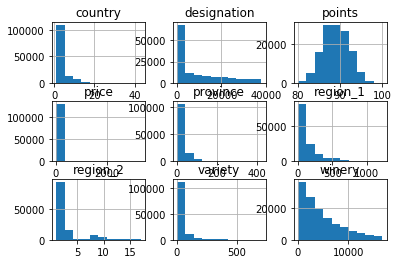

In [214]:
%matplotlib inline
transformed_data.hist()

Observe that columns have a really small amount of outliers. Lets ivestigate more precise only 'region_2' column.

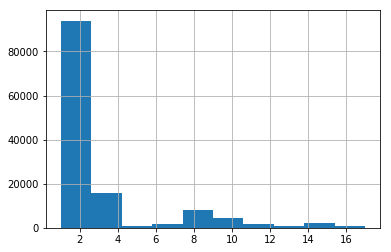

In [215]:
transformed_data.region_2.hist()

See that amount of outliers is unsignificant. The more serious problem we observe is high similarity of data. We will deal with that on the next steps

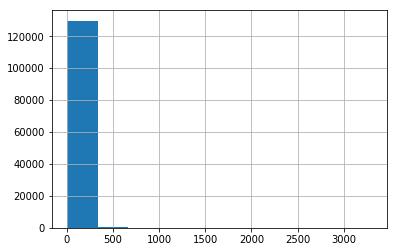

In [216]:
transformed_data.price.hist()

The problem of similarity touches almost every column of dataset, except for target column 'points', which is distributed nearly to normal.